# Импорт библиотек и датасетов

In [17]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("gauravduttakiit/banknote")
path1 = "Dataset/gauravduttakiit/banknote/versions/1"

print("Path to dataset files:", path1)

# Download latest version
#path = kagglehub.dataset_download("nikdavis/steam-store-games")
path2 = "Dataset/steam"

print("Path to dataset files:", path2)

TRAIN_PATH = path1 + "/train.csv"
TEST_PATH = path1 + "/test.csv"

Path to dataset files: Dataset/gauravduttakiit/banknote/versions/1
Path to dataset files: Dataset/steam


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)

Загрузим train и тест. Все так замечательно, что не нужно разбивать на train и тест данные.

# Анализ и визуализация данных

In [19]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [20]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (1096, 5)
Test shape: (275, 4)


Они разбиты уже соотношением 80 к 20 примерно

Посмотрим теперь на эти данные в целом. Видим 4 параметра и класс, к которому принадлежит данный объект

In [21]:
print('\nTrain columns:', train.columns.tolist())
train.head()


Train columns: ['VWTI', 'SWTI', 'CWTI', 'EI', 'Class']


,VWTI,SWTI,CWTI,EI,Class
0,2.2634,-4.4862,3.6558,-0.612510,0
1,3.2718,1.7837,2.1161,0.613340,0
2,-3.9411,-12.8792,13.0597,-3.312500,1
3,0.5195,-3.2633,3.0895,-0.984900,0
4,2.5698,-4.4076,5.9856,0.078002,0


In [22]:
print('\nTrain info:')
print(train.info())


Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VWTI    1096 non-null   float64
 1   SWTI    1096 non-null   float64
 2   CWTI    1096 non-null   float64
 3   EI      1096 non-null   float64
 4   Class   1096 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 42.9 KB
None


In [43]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VWTI    275 non-null    float64
 1   SWTI    275 non-null    float64
 2   CWTI    275 non-null    float64
 3   EI      275 non-null    float64
dtypes: float64(4)
memory usage: 8.7 KB
None


Пропусков не обнаружено, попался хороший чистый датасет

In [32]:
cols = train.columns.tolist()
target_col = "Class"

Таргет - последний столбец Class


In [33]:
print('\nClass distribution in train:')
print(train[target_col].value_counts())


Class distribution in train:
Class
0    608
1    488
Name: count, dtype: int64


Видим, что соотношение классов примерно равное

Дропаем таргет

In [45]:
X_train = train.drop(columns=[target_col])
y_train = train[target_col].values

X_test = test.copy()

print('Features shape:', X_train.shape)
print('Feature names:', X_train.columns.tolist())

Features shape: (1096, 4)
Feature names: ['VWTI', 'SWTI', 'CWTI', 'EI']


Посмотрим корреляцию

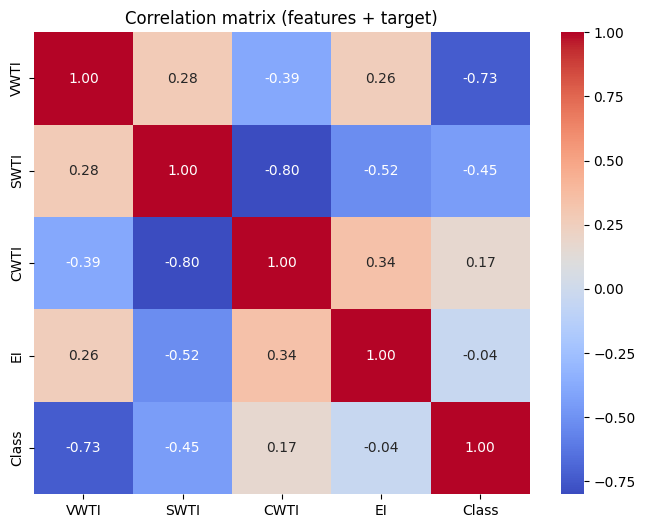

In [36]:

plt.figure(figsize=(8,6))
sns.heatmap(pd.concat([X_train, pd.Series(y_train, name=target_col)], axis=1).corr(),
            annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (features + target)')
plt.show()

По корреляции видно, что VWTI и SWTI фичи сильно влияют на наш таргет

Посмотрим на распределение фичей по нашим двум классам

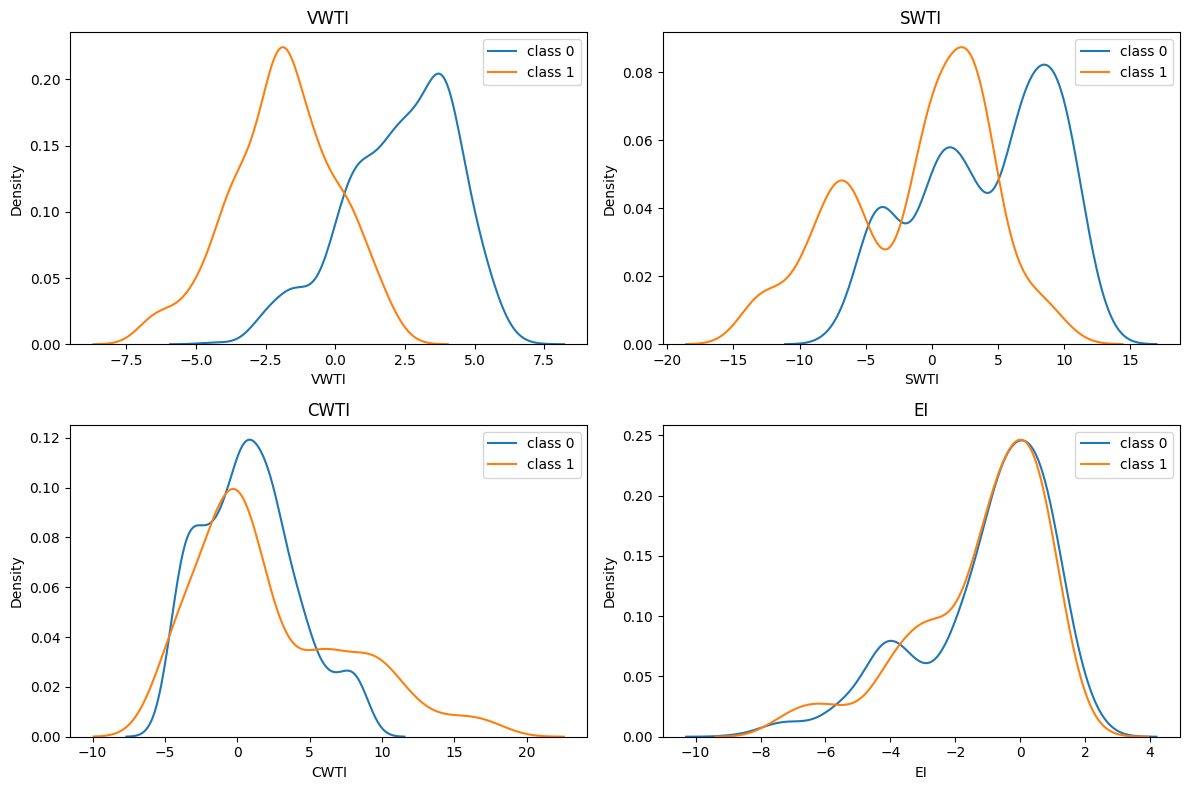

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
for i, col in enumerate(X_train.columns[:4]):
    ax = axes.flatten()[i]
    sns.kdeplot(X_train[col][y_train==0], ax=ax, label='class 0')
    sns.kdeplot(X_train[col][y_train==1], ax=ax, label='class 1')
    ax.set_title(col)
    ax.legend()
plt.tight_layout()

В подтвержение сказаному выше можно увидеть на графике явное расхождение VWTI и SWTI по двум классам

# Обучение и тестирование модели

## Базовое решение sklearn

Разделяем dataset на train/test

In [75]:
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


Обучаем

In [76]:
baseline_model = KNeighborsClassifier()
baseline_model.fit(X_train_sub, y_train_sub)

KNeighborsClassifier()

In [77]:
y_pred_baseline = baseline_model.predict(X_valid)

В качестве метрик я взял 3 штуки. Precision, Recall, Accuracy

In [84]:
acc_baseline = accuracy_score(y_valid, y_pred_baseline)
prec_baseline = precision_score(y_valid, y_pred_baseline, zero_division=0)
rec_baseline = recall_score(y_valid, y_pred_baseline, zero_division=0)

In [85]:
print(f'Accuracy: {acc_baseline:.4f}')
print(f'Precision: {prec_baseline:.4f}')
print(f'Recall: {rec_baseline:.4f}')

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


Вот оно как получается...
Ну тут не получится что-то взять и попытаться круче сделать...

Cofusion matrix

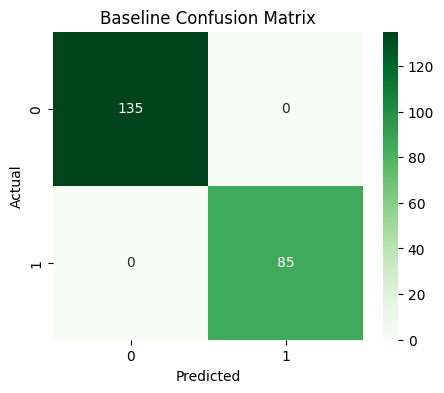

In [90]:
cm = confusion_matrix(y_valid, y_pred_baseline)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline Confusion Matrix')
plt.show()